In [ ]:
# Notebook: SciKit Learn Logistic Regression
# Author: Thomas Purk
# Date: 2025-03-28
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# Reference: https://www.ibm.com/think/topics/logistic-regression
# Reference: https://www.kaggle.com/c/titanic/data

# Logistic Regression Example

>Similar to linear regression, logistic regression is also used to estimate the relationship between a dependent variable and one or more independent variables, but it is used to make a prediction about a categorical variable versus a continuous one. A categorical variable can be true or false, yes or no, 1 or 0, et cetera. The unit of measure also differs from linear regression as it produces a probability, but the logit function transforms the S-curve into straight line.

[https://www.ibm.com/think/topics/logistic-regression](https://www.ibm.com/think/topics/logistic-regression)

A logistic regression model will be used in this project to predict one of two classes "survived" or "not survived" for a sample data set tracking passengers of the Titanic cruise ship. The data for this project comes from the popular Titanic competition on Kaggle.

(https://www.kaggle.com/c/titanic/data)[https://www.kaggle.com/c/titanic/data]

In [78]:
# Notebook Setup

# Data, Arrays, Linear Algebra
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Add for better Jupyter Notebook compatibility
%matplotlib inline

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Prevent Pandas and other warnings from displaying above outputcells, improve readability
import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once') # See warnings one time

In [2]:
# Load Data
# Source: Obtained from the "Python for Data Science and Machine Learning Bootcamp"
# Reference: https://www.udemy.com/certificate/UC-a9c3a1ee-f780-447f-8bdf-5a9c2afb8dd0/
from google.colab import files
uploaded = files.upload()

Saving titanic_train.csv to titanic_train.csv


In [59]:
# Load Data - continued
filename = list(uploaded.keys())[0]  # Get uploaded filename
df = pd.read_csv(filename)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


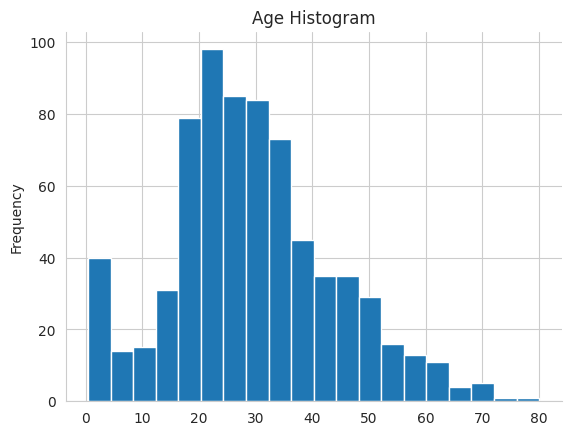

In [60]:
# @title Age

df['Age'].plot(
    kind='hist',
    bins=20,
    title='Age Histogram'
)
plt.gca().spines[['top', 'right']].set_visible(False)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Text(0.5, 1.0, 'Null Values Per Feature')

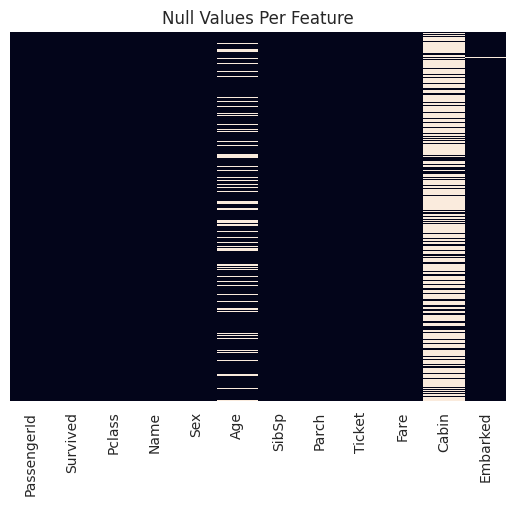

In [62]:
# Investigate Null Values
# Deal with Null Values
sns.heatmap(
    data=df.isnull(),
    yticklabels=False,
    cbar=False
)
plt.title('Null Values Per Feature')

Text(0.5, 1.0, 'Total Survived Per Class')

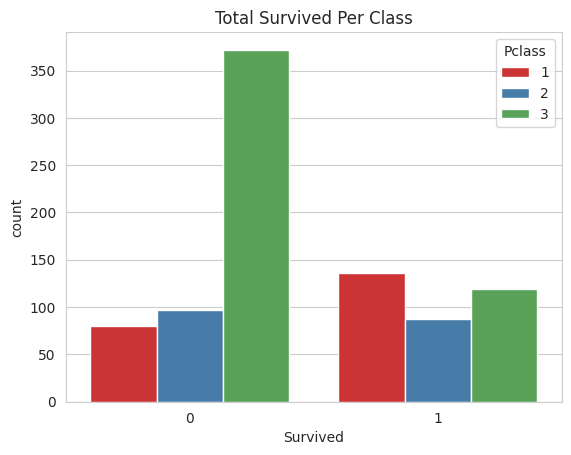

In [63]:
# Investigate Passengers who survived by ticket class
sns.countplot(
    data=df,
    x='Survived',
    hue='Pclass',
    palette='Set1'
)
plt.title('Total Survived Per Class')

Text(0.5, 1.0, 'Passengers with Siblings on Board')

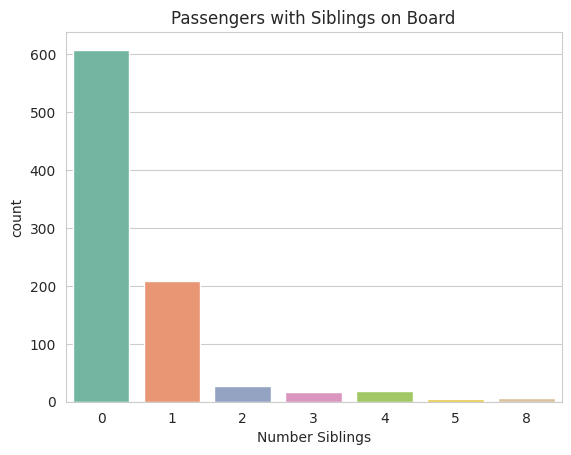

In [64]:
# Investigate Passengers who had a sibling on board
sns.countplot(
    data=df,
    x='SibSp',
    palette='Set2'
  )
plt.xlabel('Number Siblings')
plt.title('Passengers with Siblings on Board')

Text(0.5, 1.0, 'Passengers with Siblings on Board')

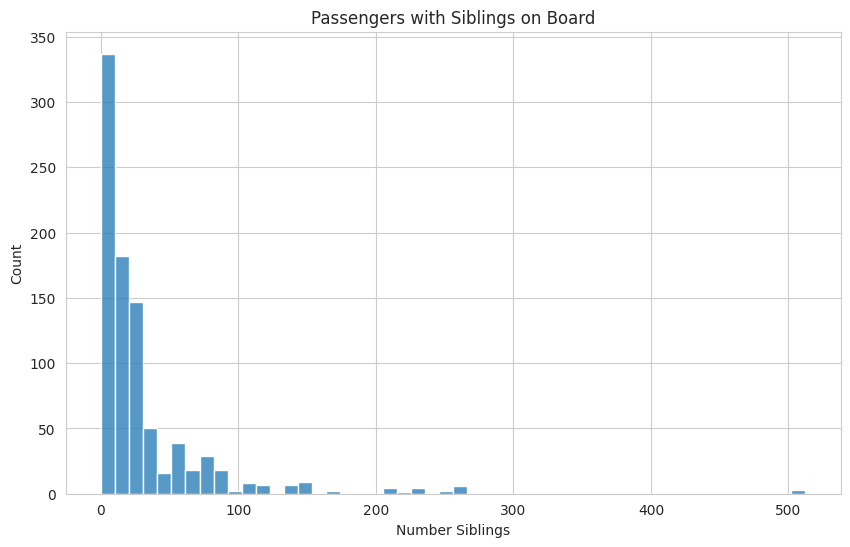

In [65]:
# Investigate Passenger counts per fare price range

plt.figure(figsize=(10, 6)) #figure size (width, height)

sns.histplot(
    data=df,
    x='Fare',
    bins=50,
    palette='Set3'
  )

plt.xlabel('Number Siblings')
plt.title('Passengers with Siblings on Board')

In [66]:
# Data Cleaning
# Prepare for Machine Learning Algorithms

# Imputation Steps
# 1. Take the Average Age and replace all NaN
# 2. Avg Age per Class and replace NaN per Class

average_age_1 = int(df[df['Pclass'] == 1]['Age'].mean())
average_age_2 = int(df[df['Pclass'] == 2]['Age'].mean())
average_age_3 = int(df[df['Pclass'] == 3]['Age'].mean())

def impute_age(cols):
    ''' Computes the age value for rows based on the passenger class average, if null
        If not null, the return the real age. This function is intended to be called
        from an apply function on a dataframe

        Parameters:
        cols (dataframe): The features and rows for which to compute age.

        Returns:
        int: The computed age
    '''

    age = cols[0]
    pclass = cols[1]

    if pd.isnull(age):
        if pclass == 1:
            return average_age_1
        elif pclass == 2:
            return average_age_2
        else:
            return average_age_3
    else:
        return age

# Apply the function to impute null age values from known values
df['Age'] = df[['Age','Pclass']].apply(impute_age,axis=1)

In [67]:
# Too many nulls in the Cabin Columns
df.drop('Cabin',axis=1,inplace=True)

In [68]:
# Drop all remaining rows with missing values
df.dropna(inplace=True)

Text(0.5, 1.0, 'Null Values Per Feature')

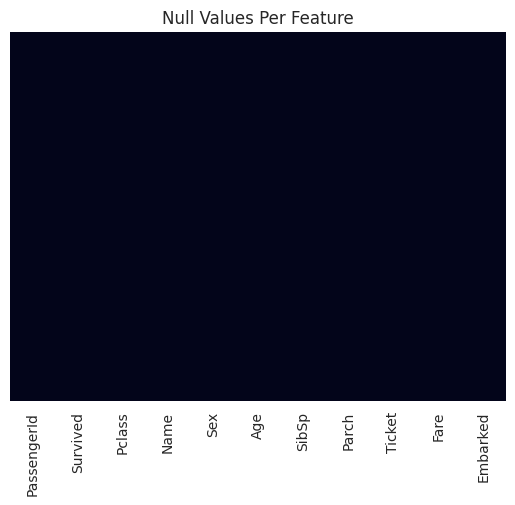

In [69]:
# Validate Age imputation and Cabin drop
# Investigate Null Values
# Deal with Null Values
sns.heatmap(
    data=df.isnull(),
    yticklabels=False,
    cbar=False
)
plt.title('Null Values Per Feature')

In [70]:
# One-hot Encode Categorical Features

sex = pd.get_dummies(
    data=df['Sex'],
    drop_first=True # Avoid milti-colinearity
)

embarked = pd.get_dummies(
    data=df['Embarked'],
    drop_first=True # Avoid milti colinearity
)

# Concatonate the new columns with the original DataFrame
df = pd.concat(
    objs=[df,sex,embarked],
    axis=1
)

# Validate
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,True,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,False,False,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,True,False,True


In [74]:
# Are the Name, PassengerID, or Ticket Feature practicle to encode?
# Highly unique values would create too many columns

print(f'Percent Uniqueness: ')
print(f'Name: {df.Name.nunique() / len(df) * 100} %')
print(f'Ticket: {df.Ticket.nunique() / len(df) * 100} %')
print(f'PassengerId: {df.PassengerId.nunique() / len(df) * 100} %')

Percent Uniqueness: 
Name: 100.0 %
Ticket: 76.4904386951631 %
PassengerId: 100.0 %


In [76]:
# Remove features that have been encoded
df.drop(
    labels=['Sex','Embarked'],
    axis=1,
    inplace=True
)

# Remove categorical features that are not practicle to encode
df.drop(
    labels=['Name','Ticket','PassengerId'],
    axis=1,
    inplace=True
)

# Validate
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


## Model Training

In [80]:
# Classification training - Predict 1 of 2 classes Survived, Not Survived

# Split the data into training and test sets
X = df.drop('Survived', axis=1)
y = df['Survived'] # The label to predict

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

# Create new model and fit it to the training data
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(
    X=X_train,
    y=y_train
)
log_reg_model

LogisticRegression(max_iter=1000)

In [83]:
# Compute the classification predictions
predictions = log_reg_model.predict(X_test)
classification_report = classification_report(y_test,predictions)

print('Classification Report: 1 = True, 0 = False')
print('')
print(classification_report)
print('')
print('precision: (true positives) / ((true positives) + (false positives))')
print('recall: (true positives) / ((true positives) + (false negatives))')
print('f1-score: 2 * ((precision * recall) / (precision + recall))')


Classification Report: 1 = True, 0 = False

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       167
           1       0.72      0.75      0.74       100

    accuracy                           0.80       267
   macro avg       0.78      0.79      0.79       267
weighted avg       0.80      0.80      0.80       267


precision: (true positives) / ((true positives) + (false positives))
recall: (true positives) / ((true positives) + (false negatives))
f1-score: 2 * ((precision * recall) / (precision + recall))


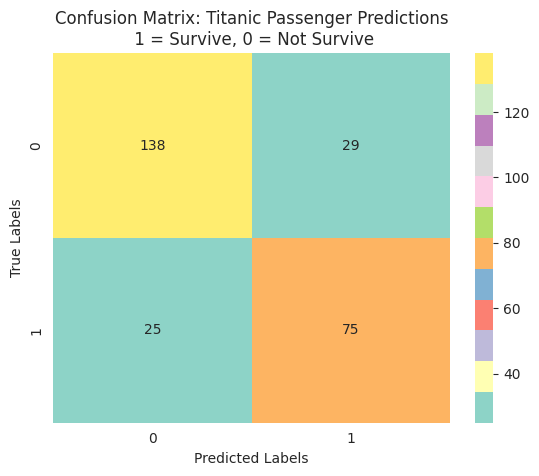

In [87]:
# Explore a confusion matrix
cm = confusion_matrix(y_test, predictions)

sns.heatmap(
    cm,
    annot=True,
    fmt='d', # string formating code
    cmap='Set3'
)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Titanic Passenger Predictions\n 1 = Survive, 0 = Not Survive')
plt.show()